<a href="https://colab.research.google.com/github/Lalasa1234/CyberbullyingDetection/blob/main/CybertextBullying_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers accelerate evaluate datasets
#safetensor contains model state and is faster and safer than pickle

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [2]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import matplotlib.pyplot as plt
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import accelerate # simplifies training in PyTorch
import torch
import evaluate
from datasets import Dataset # to convert dataframe to dataset and leverage its computational functions

In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount = True)

Mounted at /content/drive


In [4]:
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'
print (device)

cuda


In [5]:
import huggingface_hub # to download or upload repos into HuggingFace
from huggingface_hub import notebook_login
notebook_login() # access token created in HF, token enables you to create apps on HF

In [6]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Cyberbullying Detection (Text Classification)/twitter_parsed_dataset.csv')

### *EDA and Pre-Processing*

In [ ]:
df.head()

,index,id,Text,Annotation,oh_label
0,5.75E+17,5.75E+17,@halalflaws @biebervalue @greenlinerzjm I read...,none,0.0
1,5.72E+17,5.72E+17,@ShreyaBafna3 Now you idiots claim that people...,none,0.0
2,3.90E+17,3.90E+17,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,1.0
3,5.68E+17,5.68E+17,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",racism,1.0
4,5.76E+17,5.76E+17,#mkr No No No No No No,none,0.0


In [ ]:
df['Annotation'].unique()

array(['none', 'sexism', 'racism', nan], dtype=object)

In [ ]:
df['oh_label'][np.where(df['Annotation'] == 'none')[0]].unique()

array([0.])

*Remove columns not necessary for text classification problem*

1. Remove ID columns like index, id
2. All values of 'none' annotation values correspond to 0 oh_label, our objective is to classify text as toxic or not, hence removing annotation

In [7]:
df.drop(columns = ['index','id','Annotation'],inplace=True)

*Null value imputation*
1. Remove the Text that has null value
2. If text is relevant, manually de-nullify the oh-label

In [ ]:
df.isnull().sum()

,0
Text,1
oh_label,3


In [ ]:
df[pd.isnull(df['Text'])]

,Text,oh_label
2993,NaN,NaN


In [8]:
df.drop(index = [2993], inplace = True)

In [ ]:
df[pd.isnull(df['oh_label'])]

,Text,oh_label
2992,RT @Lizzethismetal: Probably gonna piss off so...,NaN
2994,1,NaN


In [9]:
df['oh_label'][2992] = 1
df.drop(index = [2994],inplace=True)

<ipython-input-9-b1b2c4ef1cf8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['oh_label'][2992] = 1


In [ ]:
df.isnull().sum()

,0
Text,0
oh_label,0


In [ ]:
df.shape

(16849, 2)

In [10]:
df['oh_label'] = df['oh_label'].astype('int') # this is necessary to debug the error that will be thrown by BCELogitswithLoss
df

,Text,oh_label
0,@halalflaws @biebervalue @greenlinerzjm I read...,0
1,@ShreyaBafna3 Now you idiots claim that people...,0
2,"RT @Mooseoftorment Call me sexist, but when I ...",1
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",1
4,#mkr No No No No No No,0
...,...,...
16846,"Feeling so sorry for the girls, they should be...",0
16847,#MKR 'pretty good dishes we're happy with' - O...,0
16848,RT @colonelkickhead: Deconstructed lemon tart!...,0
16849,@versacezaynx @nyazpolitics @greenlinerzjm You...,0


In [12]:
# Also pt models consider 1 as positive and 0 as negative, so let's align our data labels acccordingly
# where 1 stands for non-toxic text and 1 stands for toxic text

In [11]:
idx_0 = df['oh_label'][df['oh_label'] == 0].index
idx_1 = df['oh_label'][df['oh_label'] == 1].index
idx_0, idx_1

(Index([    0,     1,     4,     5,     7,     8,    10,    12,    14,    15,
        ...
        16839, 16840, 16842, 16843, 16845, 16846, 16847, 16848, 16849, 16850],
       dtype='int64', length=11501),
 Index([    2,     3,     6,     9,    11,    13,    17,    21,    23,    25,
        ...
        16822, 16823, 16825, 16826, 16831, 16832, 16834, 16836, 16841, 16844],
       dtype='int64', length=5348))

In [13]:
df['oh_label'][idx_0] = 1
df['oh_label'][idx_1] = 0
df

<ipython-input-13-ebc0e19e9424>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['oh_label'][idx_0] = 1
<ipython-input-13-ebc0e19e9424>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['oh_label'][idx_1] = 0


,Text,oh_label
0,@halalflaws @biebervalue @greenlinerzjm I read...,1
1,@ShreyaBafna3 Now you idiots claim that people...,1
2,"RT @Mooseoftorment Call me sexist, but when I ...",0
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",0
4,#mkr No No No No No No,1
...,...,...
16846,"Feeling so sorry for the girls, they should be...",1
16847,#MKR 'pretty good dishes we're happy with' - O...,1
16848,RT @colonelkickhead: Deconstructed lemon tart!...,1
16849,@versacezaynx @nyazpolitics @greenlinerzjm You...,1


### *Steps to clean data*

1. Convert all to lowercase
2. Remove all hastags (#), handles (@), hyperlinks (http)
3. Remove all characters except numbers or alphabets
4. Remove stopwords and lemmatize

In [14]:
def lower_case(text):
    return text.lower()

In [15]:
STR = '#\S+|@\S+|https?:\/\/\S+'
def remove_tweet_chars(text):
    return re.sub(STR,'',text)

In [16]:
NON_CHAR = '[^a-z0-9]+'
def remove_non_chars(text):
    return re.sub(NON_CHAR,' ',text)

In [17]:
nltk.download("stopwords")
stop = stopwords.words('english')
# Randomly add some stop words which are not already part of, check like: "id" in stop
stop.extend(["id","hve","nooo","wouldnt","gt","preeetty","bogun","ewwww","tbh","thiefs","im","dawww","rt"])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
len(stop)

192

In [18]:
lem = WordNetLemmatizer()

### *Why lemmatize only verbs*

Most of the tweets are one-line statements containing a combination of nouns and verbs. As nouns are automatically lemmatized, we consider the verb PoS tag

In [19]:
def remove_stopwords_and_lemmatize(text):
    stop_list,lem_list = [], []
    for word in str(text).split():
        if word not in stop:
            stop_list.append(word)
    for word in stop_list:
        lem_list.append(lem.lemmatize(word,'v'))
    return (' '.join(lem_list))

In [20]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [21]:
def text_preprocessing (text):
    text = lower_case(text)
    text = remove_tweet_chars(text)
    text = remove_non_chars(text)
    text = remove_stopwords_and_lemmatize(text)
    return text

In [ ]:
# Example
text_preprocessing("RT @TRobinsonNewEra: http://t.co/nkkCbpcHEo Saudi preacher who 'raped and tortured' his five -year-old daughter to death is released after â€¦")

'saudi preacher rap torture five year old daughter death release'

In [22]:
df['Text'] = df['Text'].apply(text_preprocessing)

In [23]:
df

,Text,oh_label
0,read context change mean history islamic slavery,1
1,idiots claim people try stop become terrorist ...,1
2,call sexist go auto place rather talk guy,0
3,wrong isis follow example mohammed quran exactly,0
4,,1
...,...,...
16846,feel sorry girls safe kat andre go home,1
16847,pretty good dish happy ok well never eat place,1
16848,deconstruct lemon tart please go one season wi...,1
16849,stupid talk block,1


### *Remove the duplicated values*

In [ ]:
df[df.duplicated()]

,Text,oh_label
62,kat andre fuck oxygen,0.0
154,,0.0
179,,0.0
211,,0.0
240,,0.0
...,...,...
16814,kat busy warm crack pipe bbq stand clear,1.0
16815,wait see finally win competition 27 months,0.0
16824,daesh loose half force air strike take small v...,0.0
16829,muslims celebrate international women day,0.0


In [24]:
df.drop_duplicates(inplace=True)

In [25]:
df.rename(columns = {'Text':'sentence', 'oh_label':'label'},inplace = True)

In [26]:
df

,sentence,label
0,read context change mean history islamic slavery,1
1,idiots claim people try stop become terrorist ...,1
2,call sexist go auto place rather talk guy,0
3,wrong isis follow example mohammed quran exactly,0
4,,1
...,...,...
16846,feel sorry girls safe kat andre go home,1
16847,pretty good dish happy ok well never eat place,1
16848,deconstruct lemon tart please go one season wi...,1
16849,stupid talk block,1


In [ ]:
length = []
for i in df['sentence']:
  length.append(len(i.split()))

(array([1.295e+03, 3.900e+03, 4.642e+03, 3.986e+03, 1.379e+03, 5.490e+02,
        5.000e+01, 9.000e+00, 1.000e+00, 1.000e+00]),
 array([ 0. ,  2.8,  5.6,  8.4, 11.2, 14. , 16.8, 19.6, 22.4, 25.2, 28. ]),
 <BarContainer object of 10 artists>)

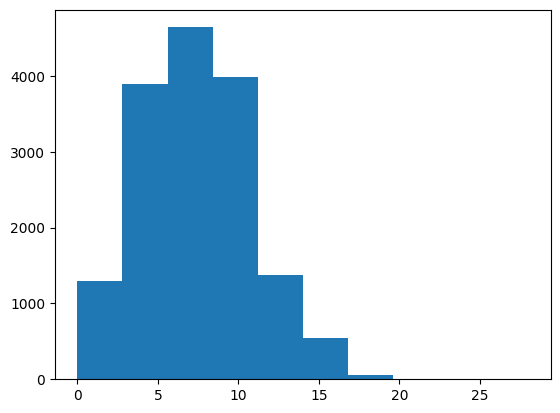

In [ ]:
plt.hist(length)

The length of every sentence is between 1 and 20, hence the max size of tokens in a vector is 20

### *Transformer: Dataset Prep.*

In [ ]:
transformers.__version__

'4.42.4'

In [27]:
ds = Dataset.from_pandas(df) # converts df to a pyarrow (APACHE-based) table as a dataset. This table has efficient memory utilization

In [28]:
ds

Dataset({
    features: ['sentence', 'label', '__index_level_0__'],
    num_rows: 15812
})

In [29]:
model_checkpoint = 'distilbert-base-uncased'
batch_size = 16
accuracy_metric = evaluate.load('accuracy')
f1_metric = evaluate.load('f1')

In [30]:
# use_fast leverages the fastest tokenizer that is backed by Rust
tok = AutoTokenizer.from_pretrained(model_checkpoint,use_fast = True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# Example
tok(df['sentence'][0]) # attention_mask = 1 relates to actual word and 0 to padding

tok(ds['sentence'][0])

{'input_ids': [101, 3191, 6123, 2689, 2812, 2381, 5499, 8864, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [31]:
# max length is 512 token for bert_cased, any input sequences greater than 512 are truncated
def tokenize(examples):
    return tok(examples['sentence'],padding='longest',truncation=True)

In [32]:
encoded_ds = ds.map(tokenize,batched=True)

Map:   0%|          | 0/15812 [00:00<?, ? examples/s]

In [33]:
id2label = {0:'TOXIC',1:'NON TOXIC'}

In [34]:
train_ds = encoded_ds.shuffle(seed=42).select(range(1000))
test_ds = encoded_ds.shuffle(seed=42).select(range(1000))
# dataset.map() is diff. from map(), it applies the function to all rows in 0 or more batches inplace in the background, tokenization happens in multi thread processing

In [ ]:
# In our dataset, 1 is toxic and 0 is non-toxic, how to deal with this- so aligned our data labels accordingly

In [35]:
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint,num_labels=2,id2label = id2label)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
model = model.to(device)

In [41]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

### *Transformer: Training*

In [45]:
args = TrainingArguments('/content/drive/MyDrive/Colab Notebooks/Cyberbullying Detection (Text Classification)/Training_Checkpoint',
                         per_device_train_batch_size=batch_size,per_device_eval_batch_size=batch_size,
                         num_train_epochs=5,learning_rate=2e-5,weight_decay=0.01,
                         eval_strategy='epoch',save_strategy='epoch',load_best_model_at_end=True,metric_for_best_model='f1',push_to_hub = True)

# weight_decay is L2 norm for weights, it tries to reduce fluctuations, keeping it simple
# Our strategy is epoch (after the training data is visited), other is step which is batch-wise
# default value of metric is loss, false if our metric is lower when better

In [46]:
def compute_metrics(eval_pred):
  predictions, labels = eval_pred # predictions are logits, we pass them through argmax to get 0 or 1
  predictions = np.argmax(predictions,axis=1)
  acc_score = accuracy_metric.compute(references=labels,predictions=predictions)['accuracy']
  f1_score = f1_metric.compute(references=labels,predictions=predictions)['f1']
  return {'accuracy':acc_score,'f1':f1_score}

In [47]:
trainer = Trainer(model=model,args=args,train_dataset=train_ds,eval_dataset=test_ds,compute_metrics = compute_metrics,
                  tokenizer = tok) # we call tok again as the sequences are padded with other batch sequence

In [48]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.349718,0.869000,0.904170
2,No log,0.240600,0.918000,0.941844
3,No log,0.152919,0.954000,0.966472
4,No log,0.117578,0.966000,0.975146
5,No log,0.106784,0.971000,0.978723


AttributeError: 'TrainOutput' object has no attribute 'to'

In [49]:
trainer.evaluate()

{'eval_loss': 0.10678372532129288,
 'eval_accuracy': 0.971,
 'eval_f1': 0.978723404255319,
 'eval_runtime': 1.8938,
 'eval_samples_per_second': 528.044,
 'eval_steps_per_second': 33.267,
 'epoch': 5.0}

In [50]:
trainer.push_to_hub()

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

events.out.tfevents.1722929949.cd88a1828bd9.791.1:   0%|          | 0.00/7.31k [00:00<?, ?B/s]

events.out.tfevents.1722930135.cd88a1828bd9.791.2:   0%|          | 0.00/457 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/LalasaMynalli/Training_Checkpoint/commit/741e0d484842043a73b4d52d69ec3bfbc982f972', commit_message='End of training', commit_description='', oid='741e0d484842043a73b4d52d69ec3bfbc982f972', pr_url=None, pr_revision=None, pr_num=None)

### *Load model from the HF repo and conduct inferencing*

In [51]:
model = AutoModelForSequenceClassification.from_pretrained('LalasaMynalli/Training_Checkpoint')

config.json:   0%|          | 0.00/675 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [52]:
model = model.to(device)

In [53]:
tok = AutoTokenizer.from_pretrained('LalasaMynalli/Training_Checkpoint',use_fast = True)

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [10]:
tok

DistilBertTokenizerFast(name_or_path='LalasaMynalli/LalasaMynalli_First_LLM', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [54]:
test = 'I hate this movie. It is pathetic'

In [63]:
inputs = tok(test,return_tensors = 'pt')

In [64]:
inputs = inputs.to(device)

In [65]:
inputs

{'input_ids': tensor([[  101,  1045,  5223,  2023,  3185,  1012,  2009,  2003, 17203,   102]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}

In [57]:
with torch.no_grad():
  logits = model(**inputs).logits

In [58]:
logits

tensor([[ 0.3060, -0.4532]], device='cuda:0')

In [61]:
pred = logits.argmax().item()
model.config.id2label[pred]

'TOXIC'

In [60]:
model.config.id2label

{0: 'TOXIC', 1: 'NON TOXIC'}

In [77]:
test = 'I am in totally in love with this place'

In [78]:
inputs = tok(test,return_tensors = 'pt')

In [79]:
inputs

{'input_ids': tensor([[ 101, 1045, 2572, 1999, 6135, 1999, 2293, 2007, 2023, 2173,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [80]:
inputs = inputs.to(device)

In [81]:
with torch.no_grad():
  logits = model(**inputs).logits

In [82]:
logits

tensor([[-0.0603, -0.0281]], device='cuda:0')

In [83]:
pred = logits.argmax().item()
model.config.id2label[pred]

'NON TOXIC'

In [84]:
print (f'{test}: {model.config.id2label[logits.argmax().item()]}')

I am in totally in love with this place: NON TOXIC
